# Response to reviewers
This notebook conducts additional analyses to address the feedback from reviewers.

Each analysis begins with a description of the configuration of each model, which includes, the specific model used for the analysis, the input and output data, and the training configuration. Then, we present and discuss the results where necessary.

To enhance visualization, the larger code cells are hidden by default, but can be expanded by clicking on the cell.

### Practical Guidelines
**Pre-executed Codes**: All code blocks have been executed, and their outputs are visible. There is no requirement to rerun them.

**Modifying Analyses**: If you wish to alter and re-execute any part of the analysis, please first save a personal copy of this notebook. You can do this by navigating to "File" -> "Save a copy in Drive". Once you've created your copy, you can import the data from the study's GitHub repository and install necessary modules by running the subsequent cell.

**Note on Compatibility**: This notebook was originally run on a local machine. If you encounter any issues with Python module compatibility, refer to the virtual environment specifications in the project's GitHub repository for guidance on installing the required packages.

In [1]:
# @title Imports
# @markdown Execute this cell to import necessary modules and define basic variables.
import random
import re

import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import clear_output
from matplotlib import pyplot as plt
from sklearn.feature_selection import SelectFromModel, VarianceThreshold
from sklearn.metrics import mean_squared_error, r2_score, classification_report
from sklearn.model_selection import (GridSearchCV, GroupKFold,
                                     GroupShuffleSplit, StratifiedGroupKFold,
                                     cross_val_score)
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, SVR, LinearSVR, LinearSVC

from pathlib import Path
from sklearn.base import TransformerMixin, BaseEstimator

## define basic variables
# feature sets using in the training
bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']
kinds = [
         'power sensor', 'power source',
         'wpli source', 'correlation source',
         'correlation sensor', 'wpli sensor'
         ]
models = [(kind, band) for kind in kinds for band in bands]

# figures setups
sns.set(style="whitegrid")
sns.set_context("paper", font_scale=1.5)

In [2]:
# @title Load Data
for kind in kinds:
  fname = '_'.join(kind.split(' '))
  data = pd.read_csv(
    f'https://raw.githubusercontent.com/Yeganehfrh/SugNet/master/derivatives/feature-extraction/{fname}.csv',
    index_col=0)
  data.to_csv(f'{fname}.csv')
  del data

# session details
DATA_with_hypnotizability = pd.read_csv("https://raw.githubusercontent.com/Yeganehfrh/SugNet/master/sourcedata/data_long_with_hypnotizability.csv")
DATA = pd.read_csv('https://raw.githubusercontent.com/Yeganehfrh/SugNet/master/sourcedata/plb_hyp_data_long.csv', index_col=0)

DATA = DATA.query('condition.str.contains("experience")').reset_index(drop=True)
DATA['bids_id'] = DATA['bids_id'].apply(lambda x: str(x).rjust(2, '0'))
DATA_with_hypnotizability['bids_id'] = DATA_with_hypnotizability['bids_id'].apply(lambda x: str(x).rjust(2, '0'))

In [3]:
# @title Helper Functions
# feature extractor
def _query_csv(path: Path,
               subject_condition: np.ndarray):
    """Query the given csv file for the given subject conditions.
    """

    data = pd.read_csv(path, index_col=0)
    data['bids_id'] = data['bids_id'].apply(int).apply(lambda x: str(x).rjust(2, '0'))
    data = data.query('condition.str.contains("experience")')
    all_idx = data[['bids_id', 'procedure']].agg(''.join, axis=1)
    valid_idx = all_idx.to_frame('idx').query('idx in @subject_condition').index
    data.drop(columns=['hypnosis_depth', 'procedure', 'description', 'session', 'condition'],
              errors='ignore', inplace=True)
    data = data.loc[valid_idx]
    return data.set_index('bids_id'), valid_idx


def _extract_features(subjects: np.ndarray,
                      kind: str,
                      frequency_band: str,
                      power_types='periodic',
                      data_dir=Path('/content'),
                      calculate_diff=False,
                      X_diff=None,
                      **kwargs) -> np.ndarray:
    """Extract features from the given subjects.

    Args:
    power_types: in ['periodic', 'nonperiodic' 'iaf', 'all'] effective only when kind is
    'power source'.
    """

    assert kind.lower() in ['power source', 'power sensor', 'power sensor relative to sham',
                            'correlation source', 'correlation sensor', 'wpli sensor', 'wpli source',
                            'power sensor real relative to sham']

    subject_condition = pd.DataFrame(subjects).agg(''.join, axis=1).to_list()
    fname = '_'.join(kind.lower().split(' ')) + '.csv'
    path = data_dir / fname
    data, valid_idx = _query_csv(path, subject_condition)
    col_names = data.columns

    if kind.lower() == 'chance':
        n_features = kwargs.get('n_features', 4)
        X = np.random.rand((len(subjects), n_features))
        return X

    elif kind.lower() == 'power sensor':
        assert power_types in ['decibel', 'absolute']
        if frequency_band != 'all':
            if power_types == 'decibel':
                col_names = [col for col in data.columns if frequency_band in col and 'decibel' in col]
            elif power_types == 'absolute':
                col_names = [col for col in data.columns if frequency_band in col and 'decibel' not in col]
    else:
        if frequency_band != 'all':
            col_names = [col for col in data.columns if frequency_band in col]

    if calculate_diff:
        X_diff = pd.DataFrame(X_diff).agg(''.join, axis=1).to_list()
        df, _ = _query_csv(path, X_diff)
        df_ = data[col_names] - df[col_names]
        return df_.set_index(valid_idx, drop=True)

    return data[col_names].set_index(valid_idx, drop=True)


class FeatureExtractor(TransformerMixin, BaseEstimator):
    def __init__(self,
                 kind: str = 'power source',
                 frequency_band: str = 'all',
                 power_types='periodic',
                 data_dir=Path('/content'),
                 calculate_diff: bool = False,
                 X_diff: np.ndarray = None,
                 **kwargs):
        self.kind = kind
        self.frequency_band = frequency_band
        self.power_types = power_types
        self.data_dir = data_dir
        self.calculate_diff = calculate_diff
        self.X_diff = X_diff
        self.kwargs = kwargs

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        self.X_ = _extract_features(X,
                                    kind=self.kind,
                                    frequency_band=self.frequency_band,
                                    power_types=self.power_types,
                                    data_dir=self.data_dir,
                                    calculate_diff=self.calculate_diff,
                                    X_diff=self.X_diff,
                                    **self.kwargs)

        return self.X_

    def get_feature_names_out(self,
                              feature_names_in: np.ndarray) -> np.ndarray:
        return self.X_.columns.values


# ------------------
def run_nested_classification_with_tuning(kind, band, power_type,
                                    X, y, groups,
                                    n_outer_split=100, n_inner_split=30,
                                    rand=False, C_rnd=None,
                                    calculate_diff=False, X_diff=None):

    model_name = f'{kind} ({band})'

    outer_cv = GroupShuffleSplit(n_splits=n_outer_split, test_size=0.3)
    inner_cv = GroupShuffleSplit(n_splits=n_inner_split, test_size=0.2)
    # inner_cv = StratifiedGroupKFold(n_splits=10, shuffle=True)

    pipe = Pipeline(steps=[
    ('zerovar', VarianceThreshold(threshold=0.0)),
    ('scale', StandardScaler()),
    ('select', 'passthrough'),
    ('clf', SVC(max_iter=1000000, kernel='linear')),
    ])

    grid_params = [{
        'clf__C': [1, 0.1, 0.01, 0.001, 10],
    }]

    # if training a chance model, we will only use the best C estimated in the main training
    if rand:
        C_rnd = C_rnd.loc[model_name]
        grid_params = [{
        'clf__C': [C_rnd]
        }]

    test_accuraies = np.array([])
    best_estimators = []

    X_ = FeatureExtractor(kind=kind, frequency_band=band, power_types=power_type,
                          calculate_diff=calculate_diff, X_diff=X_diff).fit_transform(X)

    # for i in range(90):
    for train, test in outer_cv.split(X_, y, groups):
        if rand:
            random.shuffle(y)

        # Nested CV with parameter optimization
        grid = GridSearchCV(pipe, grid_params, cv=inner_cv, scoring='accuracy', verbose=0, n_jobs=-1)
        grid.fit(X_.iloc[train], y[train], groups=groups.iloc[train])
        best_estimators.append(grid.best_estimator_)

        # accuracy on the test set using the best estimator
        y_pred = grid.predict(X_.iloc[test])
        test_accuraies = np.append(test_accuraies, (y[test] == y_pred).mean())

    return test_accuraies, best_estimators

def extract_C(best_estmators):
    C = []
    for i in range(len(best_estmators)):
        C.append(best_estmators[i]['clf'].C)
    return C

def run_nested_classification_no_tunning(kind, frequency_band, power_type, X, y,
                      groups, n_splits=50, rand=False,
                      algorithm='svm',
                      calculate_diff=False, X_diff=None):
    cv_outer = GroupShuffleSplit(n_splits=n_splits, test_size=0.3)
    cv_inner = GroupShuffleSplit(n_splits=5, test_size=0.2)

    # PIPELINE
    pipe = Pipeline(steps=[
    ('zerovar', VarianceThreshold(threshold=0.0)),
    ('scale', StandardScaler()),
    ('clf', SVC(max_iter=1000000, kernel='linear')),
    ])

    grid_params = [{}]

    X_ = FeatureExtractor(kind=kind,
                        frequency_band=frequency_band,
                        power_types=power_type,
                        calculate_diff=calculate_diff,
                        X_diff=X_diff,
                        ).fit_transform(X)

    accs = np.array([])
    for train, test in cv_outer.split(X_, y, groups):
        if rand:
            random.shuffle(y)
        grid=GridSearchCV(pipe, grid_params, cv=cv_inner, scoring='accuracy', verbose=0, n_jobs=-1)
        grid.fit(X_.iloc[train], y[train], groups=groups.iloc[train])
        y_pred = grid.predict(X_.iloc[test])
        accs = np.append(accs, (y[test] == y_pred).mean())

    return accs


def run_classification(kind, frequency_band, power_type, X, y,
                      groups, n_splits=200, rand=False,
                      algorithm='svm',
                      calculate_diff=False, X_diff=None, using_cross_val=False):
    cv = GroupShuffleSplit(n_splits=n_splits, test_size=0.3)

    # PIPELINE
    pipe = Pipeline(steps=[
    ('zerovar', VarianceThreshold(threshold=0.0)),
    ('scale', StandardScaler()),
    ('clf', SVC(max_iter=1000000, kernel='linear')),
    ])

    X_ = FeatureExtractor(kind=kind,
                        frequency_band=frequency_band,
                        power_types=power_type,
                        calculate_diff=calculate_diff,
                        X_diff=X_diff,
                        ).fit_transform(X)

    if using_cross_val:
        accs = cross_val_score(pipe, X_, y, groups=groups, cv=cv, n_jobs=-1)
        return accs

    accs = np.array([])

    for train, test in cv.split(X_, y, groups):
        if rand:
            random.shuffle(y)
        pipe.fit(X_.iloc[train], y[train])
        y_pred = pipe.predict(X_.iloc[test])
        accs = np.append(accs, (y[test] == y_pred).mean())

    return accs

def run_regression(kind, frequency_band, power_type, X, y, groups, rand=False, algorithm='svm',
                   calculate_diff=False, X_diff=None):
    mse_all = []
    r2_all = []

    cv = GroupShuffleSplit(n_splits=5, test_size=0.2)
    n_iter = 40

    if algorithm == 'svm':
        regressor = LinearSVR(dual='auto', max_iter=1000000)

    # PIPELINE
    pipe = Pipeline(steps=[
    ('zerovar', VarianceThreshold(threshold=0.0)),
    ('scale', StandardScaler()),
    ('regr', regressor),
    ])

    X_ = FeatureExtractor(kind=kind,
                          frequency_band=frequency_band,
                          power_types=power_type,
                          calculate_diff=calculate_diff,
                          X_diff=X_diff,
                          ).fit_transform(X)

    for i in range(n_iter):
        if rand:
            random.shuffle(y)
        for train, test in cv.split(X_, y, groups):
            pipe.fit(X_.iloc[train], y[train])

            mse = mean_squared_error(y[test], pipe.predict(X_.iloc[test]))
            r2 = r2_score(y[test], pipe.predict(X_.iloc[test]))

            mse_all.append(mse)
            r2_all.append(r2)

    return mse_all, r2_all

def run_all_models(kinds, frequency_bands, X, y, groups, rand=False,
                                      pipeline=run_classification,
                                      algorithm='svm',
                                      calculate_diff=False, X_diff=None,
                                      task='classification'):
    models = [(kind, band) for kind in kinds for band in frequency_bands]
    scores = {}

    for model in models:
        kind = model[0]
        band = model[1]
        model_name = f'{kind} ({band})'
        print('>>>>>', kind, band)
        scores[model_name] = pipeline(kind,
                                      band,
                                      'absolute',
                                      X, y,
                                      groups,
                                      rand=rand,
                                      algorithm=algorithm,
                                      calculate_diff=calculate_diff,
                                      X_diff=X_diff)
        if task == 'regression':
            scores['MSE_' + model_name] = scores[model_name][0]
            scores['R2_' + model_name] = scores[model_name][1]
            scores.pop(model_name)

    return pd.DataFrame(scores)

def run_classification_with_report(kind, frequency_band, power_type, X, y, groups):

    n_splits = 5
    n_iter = 40
    cv = StratifiedGroupKFold(n_splits=n_splits, shuffle=True)

    pipe = Pipeline(steps=[
    ('zerovar', VarianceThreshold(threshold=0.0)),
    ('scale', StandardScaler()),
    ('clf', SVC(max_iter=1000000, kernel='linear')),
    ])

    X_ = FeatureExtractor(kind, frequency_band, power_type).fit_transform(X)

    reports = pd.DataFrame([])

    for i in range(n_iter):
        for train, test in cv.split(X, y, groups):
            pipe.fit(X_.iloc[train], y[train])
            y_pred = pipe.predict(X_.iloc[test])

            # report
            report = pd.DataFrame(classification_report(y[test],
                                                        y_pred,
                                                        output_dict=True,
                                                        zero_division=np.nan))
            report.rename(columns={'0': 'low', '1': 'high'}, inplace=True)

            reports = pd.concat([reports, _wide_to_long(report)], axis=1)
    index = np.arange(0, n_iter * n_splits, 1)
    reports = reports.T.set_index(index)
    # values in 'recall_accuracy' is the same as the other accuracy columns, so let's drop them and keep only one
    reports.drop(columns=['precision_accuracy', 'f1-score_accuracy', 'support_accuracy'], inplace=True)
    reports.rename(columns={'recall_accuracy': 'accuracy'}, inplace=True)

    return reports

def plot_grid(grid_results, chance_scores, markersize=2, errorbar=('ci', 95),
              annotate_points=True,
              figsize=(7, 9),
              n_boot=1000,
              vline=0.57,
              plot_table=False,
              plot_chance=True,
              title=None,
              plot_first_top=None):

    grid_results = grid_results.melt()
    uniques = grid_results.groupby('variable').mean().sort_values(by='value', ascending=False)
    order = grid_results.groupby('variable')['value'].mean().sort_values(ascending=False).index.values

    if plot_first_top is not None:
        order = order[:plot_first_top]
        uniques = uniques.iloc[:plot_first_top]
        grid_results = grid_results.query('variable in @order')

    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # plot chance
    if plot_chance:
        chance_scores = chance_scores.melt()
        if plot_first_top is not None:
            chance_scores = chance_scores.query('variable in @order')
        sns.pointplot(data=chance_scores, x='value', y='variable', order=order, orient='h',
                    color='magenta', linestyles='none', capsize=0.1, n_boot=n_boot,
                    label='Chance',
                    dodge=True,
                    markersize=6,
                    errorbar=errorbar,
                    legend='full'
                    )

    # plot observed
    g = sns.pointplot(data=grid_results, x='value', y='variable', order=order, orient='h', markers='D',
                color='forestgreen', capsize=0.1, linestyles='none', n_boot=n_boot,
                label='Accuracy',
                dodge=True,
                errorbar=errorbar,
                markersize=markersize,
                legend='full'
                )

    # annotate points
    if annotate_points:
        yticks = [tick.get_text() for tick in g.get_yticklabels()]
        for x, y_txt, txt in zip(uniques['value'].values, uniques.index, uniques['value'].values):
            y = yticks.index(y_txt)
            t = plt.text(x, y, round(txt, 2), horizontalalignment='center', verticalalignment='center',
                        fontdict={'color':'white', 'size':10, 'weight':'bold'})

    if plot_table:
        # ----------------- table -----------------
        table_content = [i.split(' ') for i in uniques.index]
        table_content = [[re.sub(r'[()]', '', j).capitalize() for j in i] for i in table_content]
        col = ['Methods', 'Signals', 'Bands']
        n = len(table_content)

        # Plot
        fig.subplots_adjust(left=0.07,
                            top=1
                            )

        table = ax.table(cellText=table_content,
                            colLabels=col,
                            cellLoc='center',
                            colColours =["palegreen"]*3,
                            bbox=(-0.3, 0.0, 0.3, (n+1) / n),
                            edges='B',
                            )

        table.auto_set_font_size(False)
        table.set_fontsize(16)


        fig.canvas.draw()   # need to draw the figure twice
        plt.yticks([])
    else:
        plt.yticks(range(len(order)), [i.title() for i in uniques.index], fontsize=12)

    plt.ylabel('')
    plt.xticks(fontsize=12)
    plt.xlabel('Accuracy (%)', fontsize=12)
    plt.legend(loc="lower right", fontsize=12)
    plt.axvline(vline, color='red', linestyle='--', lw=3, alpha=1)
    plt.grid(axis='x', linestyle='--', color='gray', lw=1, alpha=0.2, zorder=0)

    if title is not None:
        plt.title(title)

    # add grid to the categorical y axis
    for y in np.arange(0, len(uniques), 1):
        ax.axhline(y, linestyle='--', color='gray', lw=2, alpha=0.5, zorder=0)

    plt.show()


def plot_result(df, thr, order, data, color='g', markersize=2, marker='D',
                baseline=True, annotate_points=True, n_boot=1000):

    df = df.query(f'threshold == {thr}')
    uniques = df.groupby('model').mean().sort_values(by='accuracy', ascending=False)
    g = sns.pointplot(data=df,
                      x='accuracy',
                      y='model',
                      order=order,
                      color=color,
                      orient='h',
                      label=thr,
                      markersize=markersize,
                      linestyles='none',
                      errorbar=('ci', 95),
                      n_boot=n_boot,
                      markers=marker)
    if baseline:
        _add_baseline_line(data['hypnosis_depth'], thr, color=color)

    # annotate points
    if annotate_points:
        yticks = [tick.get_text() for tick in g.get_yticklabels()]
        for x, y_txt, txt in zip(uniques['accuracy'].values, uniques.index, uniques['accuracy'].values):
            y = yticks.index(y_txt)
            t = plt.text(x, y, round(txt, 2), horizontalalignment='center', verticalalignment='center',
                        fontdict={'color':'white', 'size':8, 'weight':'bold'})

    plt.xticks(fontsize=10)
    plt.xlabel('Values', fontsize=10)
    plt.ylabel('Measures', fontsize=10)
    # plt.grid(axis='x', linestyle='--', color='gray', lw=2, alpha=0.5, zorder=0)

def _wide_to_long(df):
    df = df.stack().reset_index()
    df['variable'] = df['level_0'] + '_' + df['level_1']
    return df.drop(columns=['level_0', 'level_1']).set_index('variable')

def _add_baseline_line(series, thr, color='gray'):
    y = series.apply(lambda x: 0 if x <= thr else 1)
    baseline = y.value_counts(normalize=True).max()
    plt.axvline(baseline, color=color, linestyle='--', lw=2, alpha=1)

def boxplot_grid(acc, acc_rnd, order, vline=0.57, table=True, figersize=(7, 9), plot_chance=True,
                 xlim=(0.4, 0.8)):
    acc.query('variable in @order', inplace=True)
    uniques = acc.groupby('variable').mean().sort_values(by='value', ascending=False)
    if plot_chance:
        acc_rnd.query('variable in @order', inplace=True)
        acc['random'], acc_rnd['random'] = 'Actual Data', 'Shuffled Data'
        accs = pd.concat([acc, acc_rnd], axis=0)
        hue='random'
    else:
        accs = acc
        hue=None

    fig, ax = plt.subplots(1, 1, figsize=figersize)
    # change the range of x axis
    sns.boxplot(x='value', y='variable', data=accs, orient='h', hue=hue, order=order, whis=0.7, width=1,
                linewidth=2, saturation=1, ax=ax)
    plt.xlim(xlim)
    plt.xticks(fontsize=14)
    plt.xlabel('Accuracy (%)', fontsize=16)
    # # annotate boxplot with median values
    # for i in range(len(uniques)):
    #     plt.text(uniques['value'].values[i], i, round(uniques['value'].values[i], 2), horizontalalignment='center', verticalalignment='center',
    #             fontdict={'color':'white', 'size':12, 'weight':'bold'})

    if table:
        plot_table(fig, ax, uniques)
        plt.ylabel('')
        plt.yticks([])
    # change the size of the legend
    plt.legend(loc="lower right", fontsize=16)

    # add grid to the categorical y axis
    for y in np.arange(0, len(order), 1):
        ax.axhline(y, linestyle='--', color='gray', lw=2, alpha=0.5, zorder=0)

    plt.axvline(vline, color='red', linestyle='--', lw=3, alpha=1)
    plt.legend(loc="lower right", fontsize=16)
    # plt.grid(axis='x', linestyle='--', color='gray', lw=2, alpha=0.5, zorder=0)
    plt.show()

def plot_violin(accs, hue, order, uniques, vline=0.57, xlim=(0.4, 0.8),
                figersize=(7, 9),
                fontsize=12, table_fontsize=16,
                palette=['darkviolet', 'white'],
                vline_color='forestgreen',
                table=True):
    # plot a white violinplot on top to get white lines
    fig, ax = plt.subplots(1, 1, figsize=figersize)
    ax = sns.violinplot(x='value', y='variable', data=accs, hue=hue,
                   order=order,
                   split=True,
                   inner='quartile',
                   fill=True,
                   saturation=1,
                   density_norm='width', bw_method=0.2, palette=palette,
                   legend=True,
                   )

    g = sns.pointplot(x='value', y='variable', data=accs, hue='random',
                dodge=0.2, linestyles='none', errorbar=None, markers=(8,0,0),
                markersize=1, palette=palette,
                order=order, legend=False)

    # annotate points
    annotate_points(g, uniques, fontsize=13)

    # plot table
    if table:
        plot_table(fig, ax, uniques)
        plt.yticks([])
    else:
        plt.yticks(range(len(order)), [i.title() for i in order], fontsize=fontsize)

    if xlim is not None:
        plt.xlim(xlim)
    plt.legend(loc='lower right' ,title='')
    plt.ylabel('')
    plt.xlabel('Accuracy (%)', fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.axvline(vline, color=vline_color, linestyle='--', lw=3, alpha=1)
    plt.axhline(4.5, color='grey', linestyle='-', lw=3, alpha=1)

    # add text to the horizontal line to annotate top and bottom groups
    # top
    plt.text(0.91, 4.3, '\N{upwards arrow}Top Five', horizontalalignment='center', verticalalignment='center',
                    fontdict={'color':'grey', 'size':11, 'weight':'bold'})
    plt.text(0.91, 4.7, '\N{downwards arrow}Bottom Five', horizontalalignment='center', verticalalignment='center',
                    fontdict={'color':'grey', 'size':11, 'weight':'bold'})

def annotate_points(graph, uniques, fontsize=10):
    yticks = [tick.get_text() for tick in graph.get_yticklabels()]
    for x, y_txt, txt in zip(uniques['value'].values, uniques.index, uniques['value'].values):
        y = yticks.index(y_txt)
        t = plt.text(x, y-0.09, int(round(txt, 2)*100), horizontalalignment='center', verticalalignment='center',
                    fontdict={'color':'white', 'size':fontsize, 'weight':'bold'})

def plot_table(fig, ax, uniques, fontsize=10):
    table_content = [i.split(' ') for i in uniques.index]
    table_content = [[re.sub(r'[()]', '', j).capitalize() for j in i] for i in table_content]
    col = ['Methods', 'Signals', 'Bands']
    n = len(table_content)

    # Plot
    fig.subplots_adjust(left=0.07,
                        top=1
                        )

    table = ax.table(cellText=table_content,
                        colLabels=col,
                        cellLoc='center',
                        colColours =["palegreen"]*3,
                        bbox=(-0.3, 0.0, 0.3, (n+1) / n),
                        edges='B',
                        )

    table.auto_set_font_size(False)
    table.set_fontsize(fontsize)

    fig.canvas.draw()   # need to draw the figure twice

### Analysis 1: Predicitng hypnotizability Scores
This analysis addresses Comment 2 from the first reviewer.

In this section, we aim to predict hypnotizability classes using features extracted from brain data. For this purpose, we used **the same** features (30 different datasets), models (SVM classifier with a linear kernel), and conditions (specifically those described as hypnosis to the participants) as in the paper. To categorize hypnotizability scores, we organized them in two ways:

- By dividing the scores into two groups, using the median of the scores as the dividing threshold.
- By splitting the scores into three categories (low, medium, high) based on commonly used thresholds in the literature.

Before proceeding with the classification tasks, let's first prepare the data:

In [ ]:
# only include those conditions where procedure was described as hypnosis (as in the paper)
df = DATA_with_hypnotizability.query('description == "hypnosis"')

#### 1.1: Hypnotizability scores divided into two classes using median split

This section focuses on predicting hypnotizability as either low or high. We employ two distinct methods for this classification:

- Nested Cross-Validation Approach: This method, consistent with the classification setting detailed in the main paper.
- Non-Nested Cross-Validation without Hyperparameter Tuning: This alternative approach allows for the inclusion of more data in the training and validation sets by removing hyperparameter tuning.

Prior to implementing these methods, we will first prepare the necessary input and output data.

In [ ]:
# Xy
median = df['hypnotizability_total'].median()
y = df['hypnotizability_total'].apply(lambda x: 'low' if x<median else 'high').values
X = df[['bids_id','procedure']].values
groups = df['bids_id']

##### 1.1.1: Predicting hypnotizability classes (low vs. high) using nested CV

In [ ]:
scores = {}
Cs = {}
rand=False
for model in models:
    kind = model[0]
    band = model[1]
    model_name = f'{kind} ({band})'
    print('>>>>>', kind, band)
    scores[model_name], best_estimator = run_nested_classification_with_tuning(kind, band,
                                                                            'absolute', X, y, groups,
                                                                            rand=rand,
                                                                            n_inner_split=30,
                                                                            C_rnd=None)
    Cs[model_name] = extract_C(best_estimator)

scores_df = pd.DataFrame(scores)
C_df = pd.DataFrame(Cs)

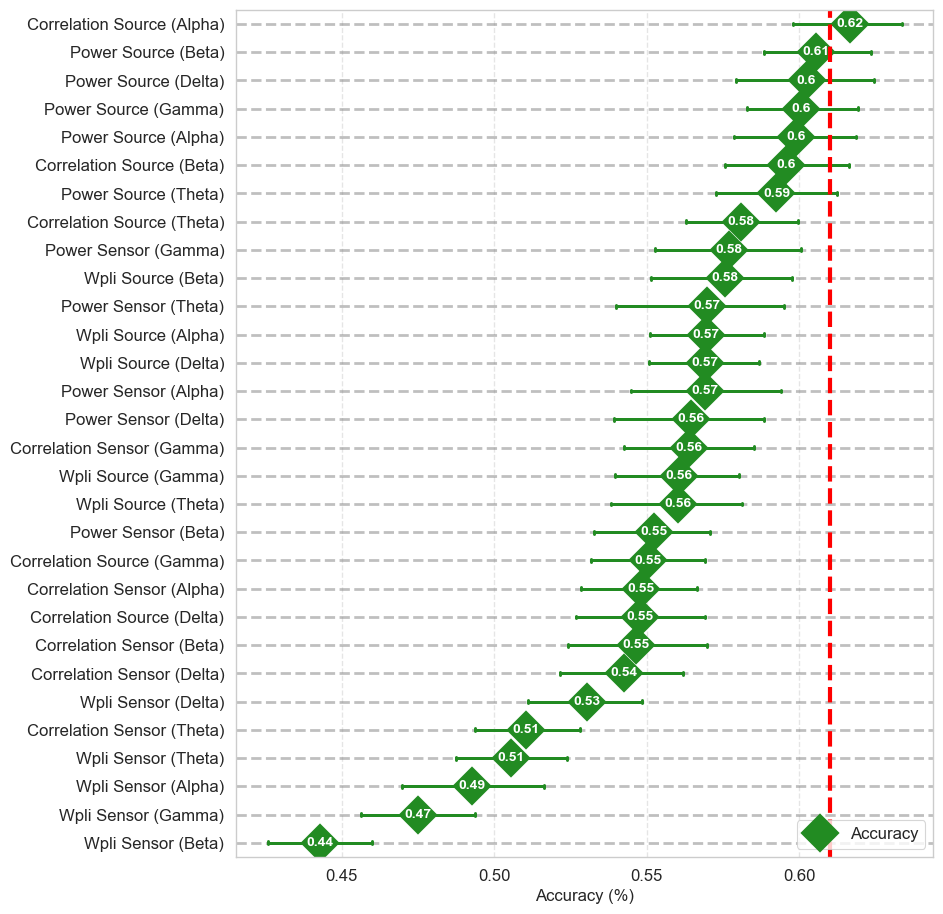

In [ ]:
plot_grid(scores_df, None, markersize=18, annotate_points=True,
          figsize=(9, 11), vline=0.61, plot_chance=False)

Using nested CV shows that all feature sets do not significantly outperform random chance at a 61% accuracy level. This method is particularly sensitive to how the model is set up. For example, changing the cross-validation method in the inner and outer loops, adjusting the number of folds and iterations can result in different outcomes. This variability is primarily because our training set is quite small, with only 47 samples. Therefore, in the next section, we will use a simpler approach: non-nested cross-validation without adjusting hyperparameters.

##### 1.1.2: Using non-nested cross-validation.

In [ ]:
accuracies = run_all_models(kinds, bands, X, y, groups, rand=False,
                            pipeline=run_classification)
accuracies_rnd = run_all_models(kinds, bands, X, y, groups, rand=True,
                                pipeline=run_classification)
clear_output()

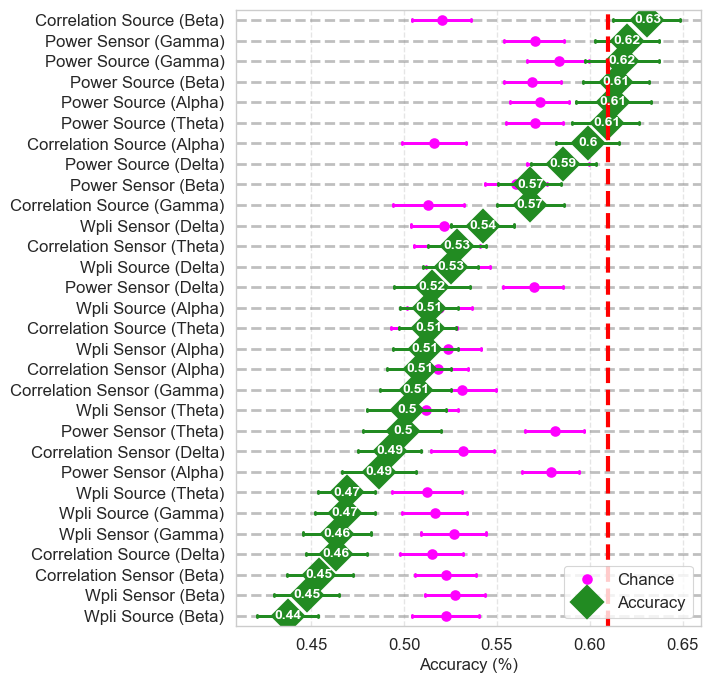

In [ ]:
plot_grid(accuracies, accuracies_rnd, markersize=16, errorbar=('ci', 99), figsize=(6, 8),
          vline=0.61, plot_first_top=30, n_boot=5000)

Increasing the number of samples in the training and test sets leads to improved performance. In this instance, the Correlation Source (beta) feature sets show a slight improvement over random chance levels.

However, feature sets at the lower end of the plot underperform compared to the permuted null model. This underperformance could be due to the lack of regularization in our approach, leading to overfitting on the training data and reduced generalizability to the test data.

#### 1.2: Hypnotizability Scores Divided into Three Classes (low, medium, high)

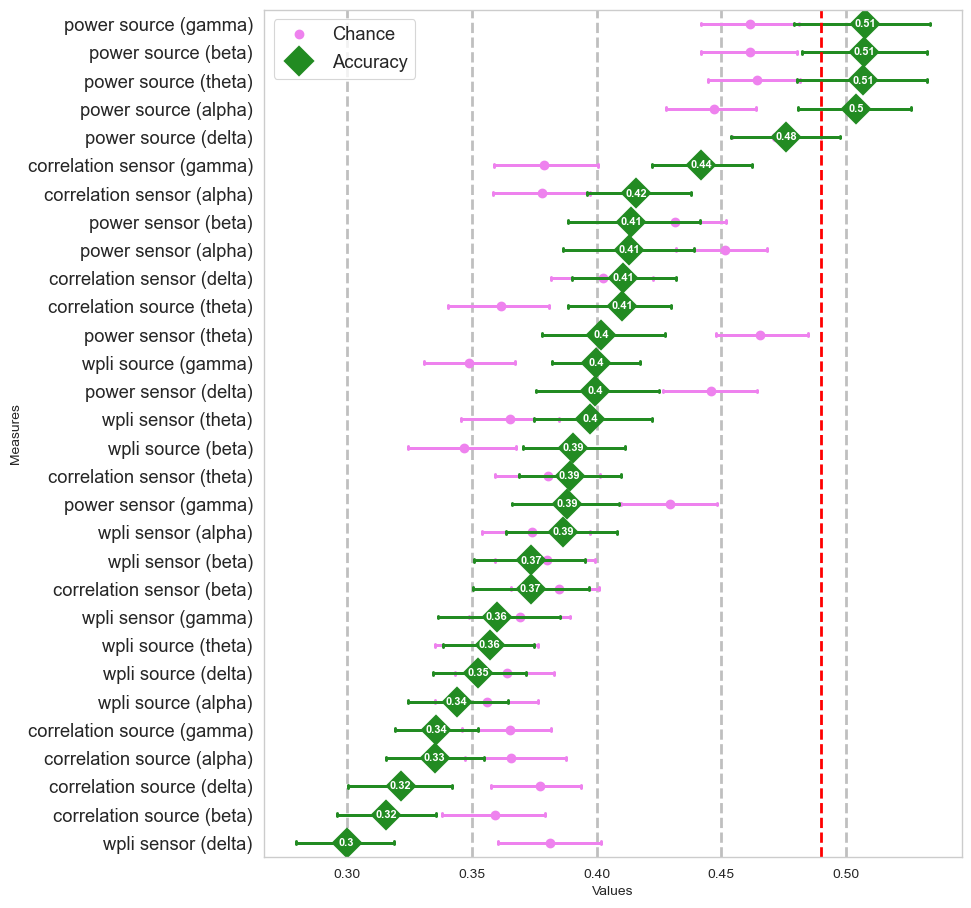

In [ ]:
# output target variable
y = DATA_with_hypnotizability['hypnotizability_total'].apply(lambda x: 'low' if x <=4 else 'medium' if x<8 else 'high').values

# train
accuracies = run_all_models(kinds, bands, X, y, groups, rand=False)
accuracies_rnd = run_all_models(kinds, bands, X, y, groups, rand=True)
clear_output()

# plot
plot_grid(accuracies, accuracies_rnd, markersize=14, annotate_points=True, figsize=(9, 11),
          plot_vline=False)
plt.axvline(0.49, color='red', linestyle='--', lw=2, alpha=1)

In [ ]:
unique, counts = np.unique(y, return_counts=True)
unique_groups = dict(zip(unique, counts))
print('>>> chance_level=', unique_groups[1] / len(y) * 100)

hypnotizability_total
medium    0.494118
low       0.294118
high      0.211765
Name: proportion, dtype: float64

When the scores are categorized into three classes (low, medium, high), the distribution of samples in each class is **30%, 49%, and 21%**, respectively. The red vertical line in the graph represents the chance level at **49%**, correlating with the proportion of the most prevalent class. None of the models surpass this chance level in performance. This limitation may be due to the small sample size for a multiclass classification task, which typically requires a larger samples compared to binary classification.

### Analysis 2: Predicting Hypnotic Depth Using Differences Between Hypnosis and Control Conditions.

This analysis responds to Comment 18 from the first reviewer.

The setup for this analysis is outlined below:

- **Model**: SVM classifier with a linear kernel.

- **Input Data**: The difference between features extracted from brain data under hypnosis conditions (as described in the main paper) and those under control conditions (where non-conventional induction procedures were introduced as controls).

- **Output Data**: The difference in hypnotic depth scores between hypnosis and control conditions, classified into two groups using a median split.

- **Cross-Validation**: Nested cross-validation using GroupShuffleSplit method, repeated 100 times in the outer loop and 30 times in the inner loop. We used GridSearchCV to fine-tune the C parameter in the SVM model.

- **Conditions included in this analysis**: Three of the four experimental conditions are included: conventional and non-conventional inductions (described as hypnosis), and non-conventional induction (described as control). In fact, the control condition is the one that we did not include in our main analysis in the paper and is used here for normalization.

First, let's prepare the input data:

In [ ]:
df = DATA.copy()
df['procedure_type'] =  df['procedure'].apply(lambda x: 'hypnosis'
                                                  if (x=='relaxation' or x=='confusion')
                                                      else 'control')
df = df.drop(df.query('procedure_type == "hypnosis" and description == "control"').index)
X = df.query('description == "hypnosis"')[['bids_id','procedure']].values
X_con = df.query('description == "control"')[['bids_id','procedure']].values
groups = df.query('description == "hypnosis"')['bids_id']

df.set_index('bids_id', inplace=True)
depth_hyp = df.query('description == "hypnosis"')['hypnosis_depth']
depth_con = df.query('description == "control"')['hypnosis_depth']

y = depth_hyp - depth_con
median = y.median()
y = y.apply(lambda x: 1 if x >= median else 0)
print(y.value_counts(normalize=True))
y = y.values

hypnosis_depth
1    0.538462
0    0.461538
Name: proportion, dtype: float64


In [ ]:
# @title train model (should run this cell twice, one with rand=False and one with rand=True).
rand = False

models = [(kind, band) for kind in kinds for band in bands]
scores = {}
Cs = {}
C_rnd = pd.read_csv(
'https://raw.githubusercontent.com/Yeganehfrh/SugNet/master/derivatives/feature-extraction/finetuned-C/C_analysis2.csv',
index_col=0)
for model in models:
    kind = model[0]
    band = model[1]
    model_name = f'{kind} ({band})'
    print('>>>>>', kind, band)
    scores[model_name], best_estimator = run_nested_classification_with_tuning(kind, band,
                                                                            'absolute', X, y, groups,
                                                                            rand=rand,
                                                                            n_inner_split=30,
                                                                            C_rnd=C_rnd.mean(),
                                                                            calculate_diff=True,
                                                                            X_diff=X_con)
    Cs[model_name] = extract_C(best_estimator)

if not rand:
    scores_df = pd.DataFrame(scores)
    C_df = pd.DataFrame(Cs)

if rand:
  accs_rnd = pd.DataFrame(scores)

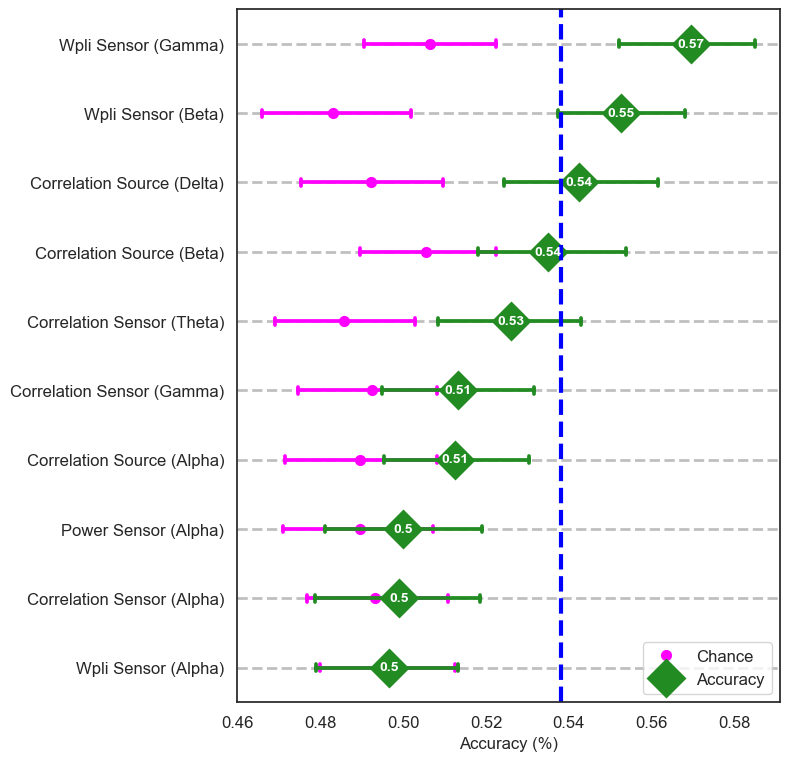

In [ ]:
plot_grid(scores_df, accs_rnd, markersize=18, annotate_points=True,
          figsize=(7, 9), vline=0.538, plot_chance=True, plot_first_top=10)

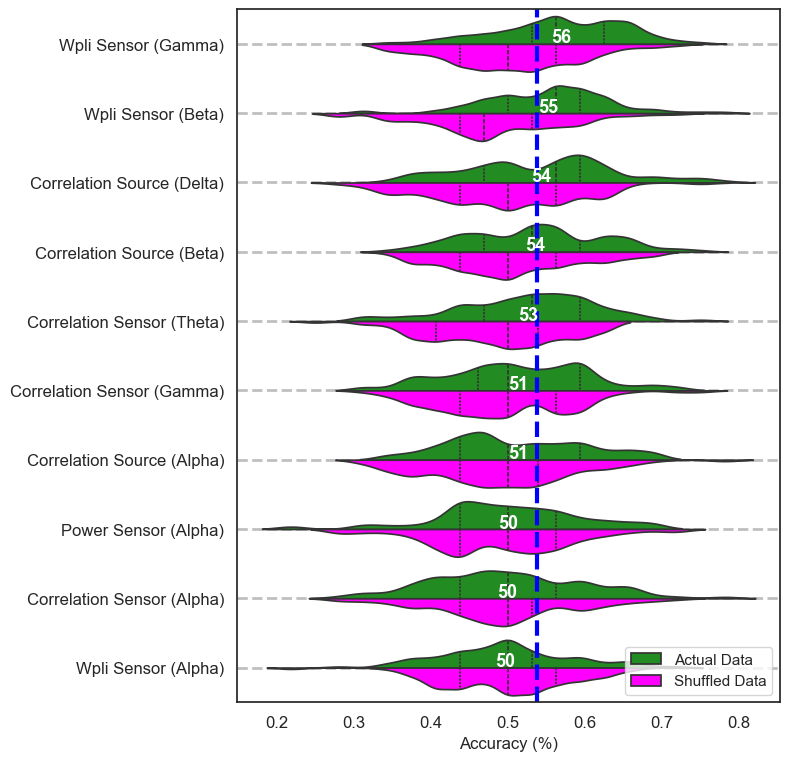

In [ ]:
# @title Violin Plot
accs_rand, scores_df = accs_rnd.melt(), scores_df.melt()
order = scores_df.groupby('variable')['value'].mean().sort_values(ascending=False).index.values
unique = scores_df.groupby('variable').mean().sort_values(by='value', ascending=False)
accs_rand['random'], scores_df['random'] = 'Shuffled Data', 'Actual Data'
accs = pd.concat([scores_df, accs_rand], axis=0)
order = order[:10]
unique = unique.iloc[:10]
accs = accs.query('variable in @order')

# plot
plot_violin(accs, 'random', order, unique, vline=0.538, xlim=None, figersize=(7, 9),
            annot_top_bottom=False, table=False, palette=['forestgreen', 'magenta'], vline_color='blue')

When we use the differences between feature values from hypnosis and control conditions to predict variations in hypnotic depth, divided into two categories, the classifier based on **gamma wPLI connectivities** is the higher performing feature set. This finding is consistent with our initial analysis where this feature set stands as the third most effective set and hoghlights the importance of Gamma oscillations in predicting self-reported hypnotic experience.

### Analysis 3: Using Regression Analysis for Predicting Hypnotic Depth Scores

This analysis addresses Comment 20 from the first reviewer and is structured as follows:

- **Model**: SVM regressor with a linear kernel.

- **Input Data**: 30 different datasets comprising features extracted from brain data.

- **Output Data**: Hypnotic depth scores, which range from 0 to 10.

- **Cross-Validation**: involves a 5-fold GroupShuffledSplit, which is non-nested and repeated 40 times. This repetition helps in obtaining confidence intervals for the results.

- **Conditions**: The analysis includes only those experimental blocks that the induction were described as hypnosis, similar to the main analysis in the paper.

In [ ]:
# @title prepare data and train models
df = DATA.copy()
df = df.query('description == "hypnosis"')
X = df[['bids_id','procedure']].values
y = df['hypnosis_depth'].values
groups = df['bids_id']

accs = run_all_models(kinds, bands, X, y, groups, rand=False, pipeline=run_regression,
                        task='regression')

accs_rnd = run_all_models(kinds, bands, X, y, groups, rand=True, pipeline=run_regression,
                                task='regression')

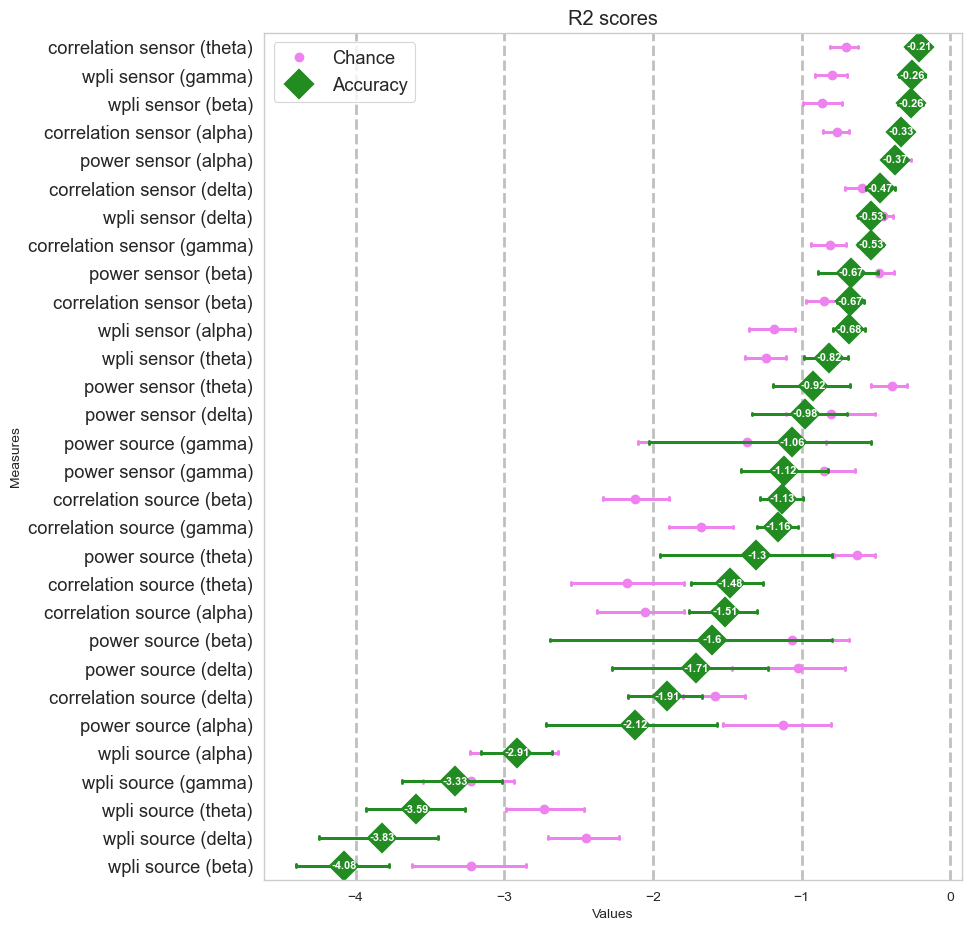

In [ ]:
# plot
r2_scores, r2_scores_rnd = accs.filter(regex='R2'), accs_rnd.filter(regex='R2')

# remove r2 from the columns names
r2_scores.columns = r2_scores.columns.str.replace('R2_', '')
r2_scores_rnd.columns = r2_scores_rnd.columns.str.replace('R2_', '')

plot_grid(r2_scores, r2_scores_rnd, markersize=14, annotate_points=True, figsize=(9, 11),
          plot_vline=False, title='R2 scores')

The R2 scores from all datasets appear to be pretty low, with some even dipping into negative values. This indicates that the model's performance is arbitrarily worse than what would be expected by chance. To understand why this might be, it's instructive to visualize the relationship between the predicted hypnotic depth values and the top feature, specifically the mid frontal feature in the top dataset, the gamma power sensor data, as an example. This analysis could provide insights into the underlying reasons for the subpar performance of the regression models.

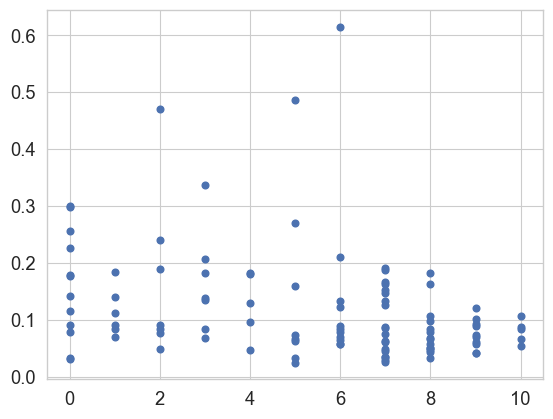

In [ ]:
power = FeatureExtractor(kind='power sensor', frequency_band='gamma', power_types='absolute').fit_transform(X)
plt.plot(y, power['FZ_gamma'], 'o')

The figure indicates a lack of linear relation between the top feature in the best-performing model and the hypnotic depth scores, especially when treating these scores as continuous. The graph also suggests that the predicted values lean more towards categorical classification rather than continuous, implying that they might be better predicted using a classifier instead of a regressor.

Given these observations, shifting to a multiclass classification approach could potentially yield improved performance. However, considering our small sample size, it's unlikely that the results would be statistically significant.

### Analysis 4: Sensitivity Analysis: Adjusting Cutoff in Hypnotic Depth Categorization

This analysis responds to Comment 20 from the first reviewer.

Our objective is to determine the sensitivity of our results to the cutoff threshold used for binarizing hypnotic depth scores.

In this process, we maintain **the same configuration** as in our main study, but we will apply different cutoff points (4, 5, and 6) to binarize the hypnotic depth scores.

The **cross-validation** method here also differs from that used in the paper. We use the **StratifiedShuffleSplit** method for cross-validation with 5-folds and repeating it 40 times. This is becuase different cutoffs result in varying numbers of samples in each class, so we use stratified sampling to ensure that the proportion of samples in each class remains consistent in both the training and test sets.

In [ ]:
df = DATA.copy()
df = df.query('description == "hypnosis"')
X = df[['bids_id','procedure']].values
groups = df['bids_id']

In [ ]:
# @title Training models with different cutoff values

cutoffs = [4, 5, 6]
report_cutoffs = {}
report_models = {}

model_names = []
for model in models:
    kind = model[0]
    frequency_band = model[1]
    model_name = f'{kind} ({frequency_band})'
    print('>>>', model_name)
    for thr in cutoffs:
        print('>>>>>', thr)
        y = df['hypnosis_depth'].apply(lambda x: 0 if x <= thr else 1).values
        report = run_classification_with_report(kind, frequency_band, 'absolute', X, y, groups)
        report_cutoffs[thr] = report
        model_names.append(model_name)

    df_cutoffs = pd.concat(report_cutoffs, axis=0, keys=cutoffs)
    report_models[model_name] = df_cutoffs

df_models = pd.concat(report_models, axis=0, keys=model_names)

# plot only accuracies columns for all feature sets and theresholds
df_models_acc = df_models.filter(regex='accuracy')
df_models_acc = df_models_acc.reset_index().drop(columns='level_2')
df_models_acc.rename(columns={'level_0': 'model', 'level_1': 'threshold',
                              'f1-score_weighted avg': 'accuracy'}, inplace=True)

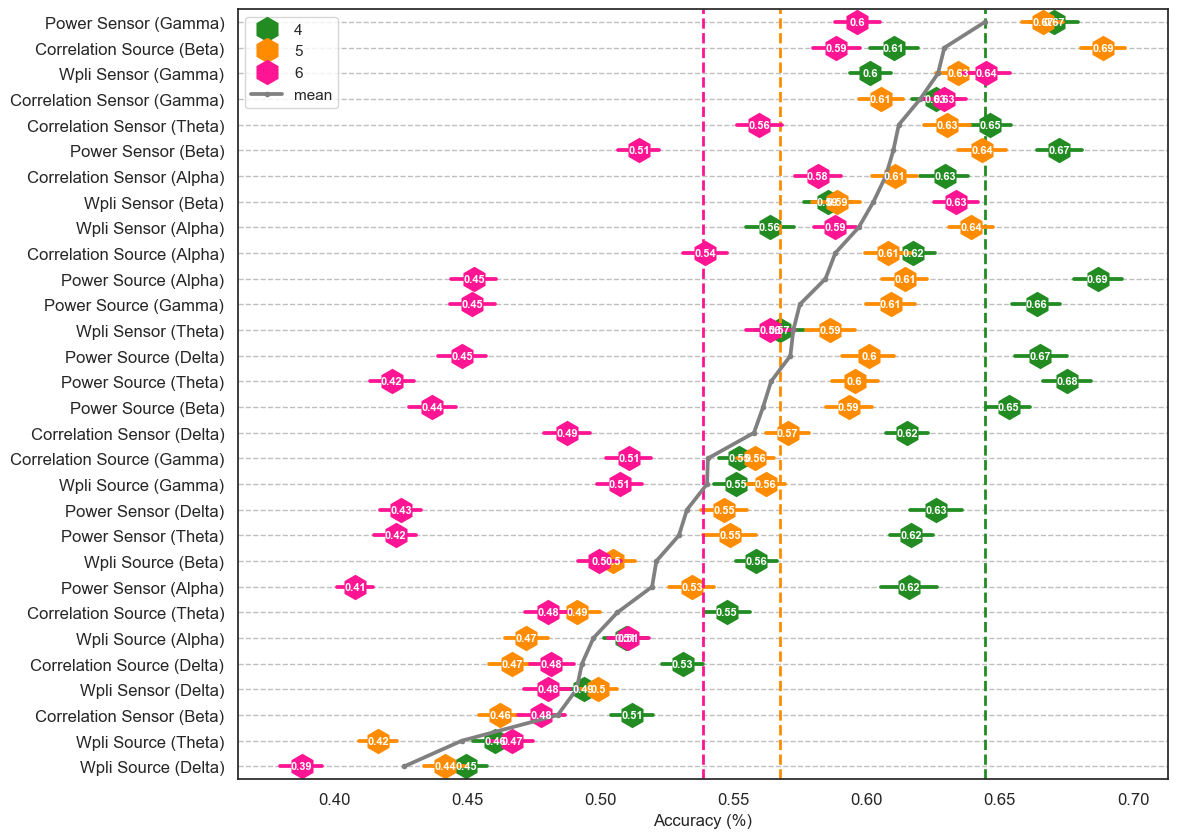

In [ ]:
# @title Visualisation
sns.set(rc={'figure.figsize':(12,10)})
sns.set(style="white")
cutoffs = [4, 5, 6]
order = df_models_acc.groupby('model')['accuracy'].mean().sort_values(ascending=False).index.values
colors = ['forestgreen', 'darkorange', 'deeppink']
for thr, color in zip(cutoffs, colors):
    plot_result(df_models_acc,
                thr,
                order=order,
                data=df,
                color=color,
                marker='h',
                markersize=16,
                n_boot=1000,)

# add average performance to the plot
means = df_models_acc.groupby('model')['accuracy'].mean().sort_values(ascending=False).to_frame().reset_index()
sns.pointplot(data=means,
                   x='accuracy',
                   y='model',
                   order=order,
                   label='mean',
                   color='gray',
                   orient='h',
                   markersize=2)
plt.legend(title='Threshold')

y_ticks = [i.title() for i in order]
plt.yticks(list(range(0, 30)), y_ticks, fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel('Accuracy (%)', fontsize=12)
plt.ylabel('')

# add horizontal grids
for y in np.arange(0, 30, 1):
    plt.axhline(y, linestyle='--', color='gray', lw=1, alpha=0.5, zorder=0)

plt.legend(loc='upper left')

### Analysis 5: Predicting Description Types

This analysis addresses Comment 30 from the first reviewer and is structured as follows:

- **Model**: a SVM classifier with a linear kernel.

- **Input Data**: 30 datasets, each featuring brain-extracted data.

- **Output Data**: The description types, which indicates whether the experimental block was described as ***hypnosis*** or ***control***.

- **Cross-Validation**: Nested cross-validation using GroupShuffleSplit, repeated 100 times in the outer loop and 30 times in the inner loop. We used GridSearchCV to tune the C parameter in SVM model.

- **Conditions**: This analysis encomincludespasses all experimental blocks of the study. However, data from one experimental block of a participant has been excluded due to a programming error during data collection; therefore, the total number of samples in this analysis is 207.

In [ ]:
# 1. DATA
df = DATA.copy()
# Xy
X = df[['bids_id','procedure']].values
groups = df['bids_id']
y = df['is_it_real'].values

In [ ]:
# @title This cell should be executed twice: one time set rand=True and one time set it False to have the models
# trained with both actual and random data.
rand=False
scores = {}
Cs = {}
c_rnd = pd.read_csv(
    'https://raw.githubusercontent.com/Yeganehfrh/SugNet/master/derivatives/feature-extraction/finetuned-C/C_analysis5.csv',
    index_col=0)
for model in models:
    kind = model[0]
    band = model[1]
    model_name = f'{kind} ({band})'
    print('>>>>>', kind, band)
    scores[model_name], best_estimator = run_nested_classification_with_tuning(kind, band,
                                                                            'absolute', X, y, groups,
                                                                            rand=rand,
                                                                            n_inner_split=30,
                                                                            C_rnd=C_rnd.mean())
    Cs[model_name] = extract_C(best_estimator)

if rand:
  accs_desc_rnd = pd.DataFrame(scores)

if not rand:
  accs_desc = pd.DataFrame(scores)
  C_df = pd.DataFrame(Cs)

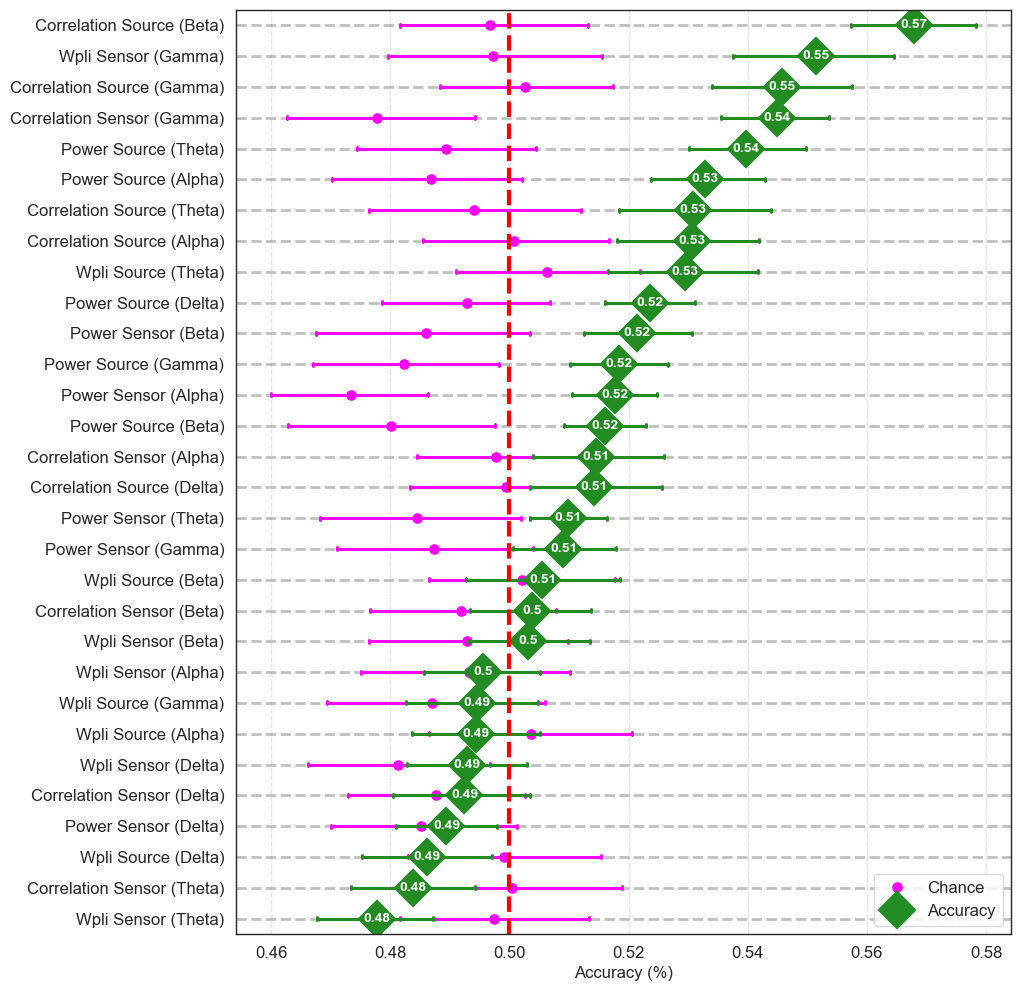

In [ ]:
plot_grid(accs_desc, accs_desc_rnd, markersize=18, figsize=(10, 12), vline=0.5,
          errorbar=('ci', 99), n_boot=5000)

The results shows that the type of description given to participants (control or hypnosis) affected the specific EEG features. In particular, the beta Power Envelope Correlation (PEC) at the source level was the most effective in differentiating the description type, the feature set that was also effective at classifying the participants' reported hypnotic depth and their hypnotizability group.